In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *

     |████████████████████████████████| 719 kB 4.7 MB/s 
     |████████████████████████████████| 1.3 MB 50.3 MB/s 
     |████████████████████████████████| 4.7 MB 46.6 MB/s 
     |████████████████████████████████| 365 kB 59.8 MB/s 
     |████████████████████████████████| 115 kB 71.0 MB/s 
     |████████████████████████████████| 212 kB 65.9 MB/s 
     |████████████████████████████████| 101 kB 13.8 MB/s 
     |████████████████████████████████| 141 kB 68.8 MB/s 
     |████████████████████████████████| 596 kB 68.0 MB/s 
     |████████████████████████████████| 127 kB 72.6 MB/s 
     |████████████████████████████████| 6.6 MB 31.3 MB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

Path.BASE_PATH = path

In [3]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

In [4]:
# Images per breed category
len((path/"images").ls()) / len(dls.vocab)

199.8108108108108

In [5]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.548192,0.340060,0.107578,01:21


epoch,train_loss,valid_loss,error_rate,time
0,0.487988,0.340511,0.112314,01:21
1,0.323574,0.216228,0.062246,01:19


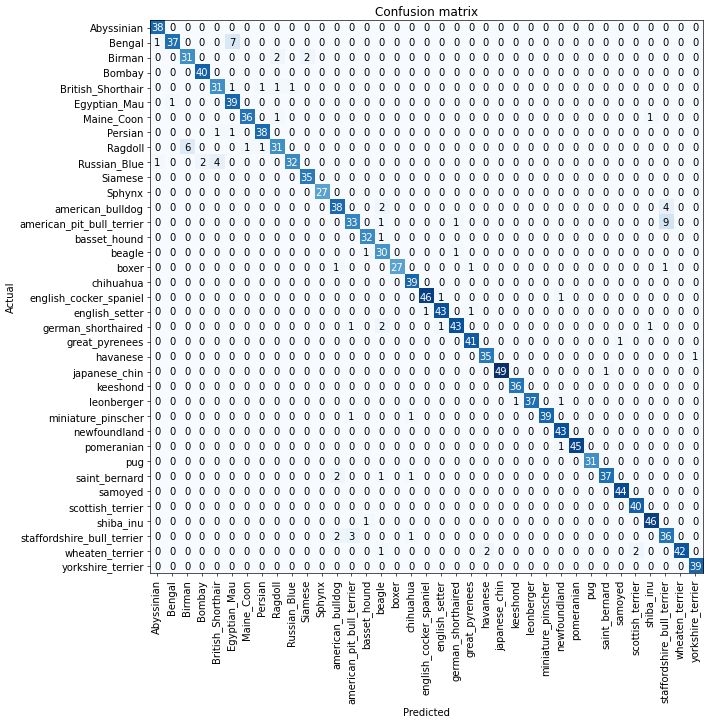

In [6]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [7]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('Bengal', 'Egyptian_Mau', 7),
 ('Ragdoll', 'Birman', 6)]

Use learning rate finder for starting learning rate

Minimum/10: 1.00e-02, steepest point: 5.25e-03


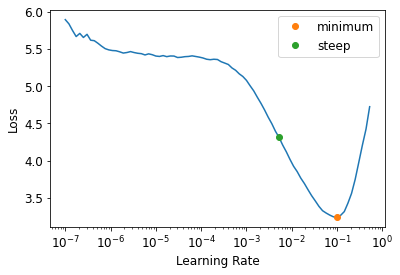

In [8]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Add descriminative learning rate

In [9]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 5e-3)
learn.unfreeze()
learn.fit_one_cycle(8, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.040845,0.483945,0.144114,01:12
1,0.575766,0.302975,0.089986,01:13
2,0.360150,0.226740,0.066982,01:13


epoch,train_loss,valid_loss,error_rate,time
0,0.268128,0.216425,0.065629,01:15
1,0.241365,0.200918,0.063599,01:16
2,0.223239,0.202127,0.061570,01:16
3,0.196635,0.192846,0.058187,01:15
4,0.198316,0.192932,0.059540,01:17
5,0.168589,0.191125,0.058863,01:16
6,0.151008,0.187889,0.060893,01:16
7,0.154455,0.187506,0.058187,01:15


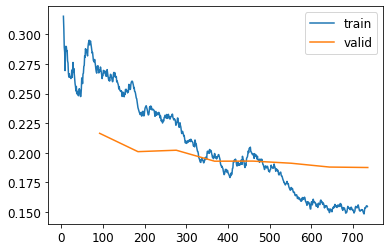

In [10]:
learn.recorder.plot_loss()